In [7]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Dict, Any
from abc import ABC, abstractmethod
# from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
    classification_report
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Generating kNN Class
class KNN(ABC):
    """
    Base class for KNN implementations
    """

    def __init__(self, K: int = 3, metric: str = 'minkowski', p: int = 2) -> None:
        """
        Initializer function. Ensure that input parameters are compatible.
        Inputs:
        K -> integer specifying the number of neighbours to consider
        metric -> string to indicate the distance metric to use (valid entries are 'minkowski' or 'cosine')
        p -> order of the minkowski metric (valid only when distance == 'minkowski')
        """
        # check distance is a valid entry
        valid_distance = ['minkowski', 'cosine']
        if metric not in valid_distance:
            msg = "Entered value for metric is not valid. Pick one of {}".format(valid_distance)
            raise ValueError(msg)

        # check minkowski p parameter
        if (metric == 'minkowski') and (p <= 0):
            msg = "Entered value for p is not valid. For metric = 'minkowski', p >= 1"
            raise ValueError(msg)

        # store/initialize input parameters
        self.K = K
        self.metric = metric
        self.p = p
        self.X_train = np.array([])
        self.y_train = np.array([])

    def __del__(self) -> None:
        """
        Destructor function.
        """
        del self.K
        del self.metric
        del self.p
        del self.X_train
        del self.y_train

    def __minkowski(self, x: np.array) -> np.array:
        """
        Private function to compute the minkowski distance between point x and the training data X
        Inputs:
        x -> numpy data point of predictors to consider
        Outputs:
        np.array -> numpy array of the computed distances
        """
        return np.power(np.sum(np.power(np.abs(self.X_train - x), self.p), axis=1), 1 / self.p)

    def __cosine(self, x: np.array) -> np.array:
        """
        Private function to compute the cosine distance between point x and the training data X
        Inputs:
        x -> numpy data point of predictors to consider
        Outputs:
        np.array -> numpy array of the computed distances
        """
        return 1 - (np.dot(self.X_train, x) / (np.linalg.norm(x) * np.linalg.norm(self.X_train, axis=1)))

    def __distances(self, X: np.array) -> np.array:
        """
        Private function to compute distances to each point x in X[x,:]
        Inputs:
        X -> numpy array of points [x]
        Outputs:
        D -> numpy array containing distances from x to all points in the training set.
        """
        # cover distance calculation
        if self.metric == 'minkowski':
            D = np.apply_along_axis(self.__minkowski, 1, X)
        elif self.metric == 'cosine':
            D = np.apply_along_axis(self.__cosine, 1, X)
        # return computed distances
        return D

    @abstractmethod
    def _generate_predictions(self, idx_neighbours: np.array) -> np.array:
        """
        Protected function to compute predictions from the K nearest neighbours
        """
        pass

    def fit(self, X: np.array, y: np.array) -> None:
        """
        Public training function for the class. It is assumed input X has been normalized.
        Inputs:
        X -> numpy array containing the predictor features
        y -> numpy array containing the labels associated with each value in X
        """
        # store training data
        self.X_train = X
        self.le = LabelEncoder()
        self.y_train = self.le.fit_transform(y)

    def predict(self, X: np.array) -> np.array:
        """
        Public prediction function for the class. It is assumed input X has been normalized in the same fashion as the input to the training function
        Inputs:
        X -> numpy array containing the predictor features
        Outputs:
        y_pred -> numpy array containing the predicted labels
        """
        # ensure we have already trained the instance
        if (self.X_train.size == 0) or (self.y_train.size == 0):
            raise Exception('Model is not trained. Call fit before calling predict.')

        # compute distances
        D = self.__distances(X)
        # obtain indices for the K nearest neighbours
        idx_neighbours = D.argsort()[:, :self.K]
        # compute predictions
        y_pred = self._generate_predictions(idx_neighbours)
        # return results
        return y_pred

    def get_params(self, deep: bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
        deep -> boolean input parameter
        Outputs:
        Dict -> dictionary of stored class input parameters
        """
        return {'K': self.K,
                'metric': self.metric,
                'p': self.p}

# Generating kNN Classifier
class KNNClassifier(KNN):
    """
    Class for KNN classification implementation
    """

    def __init__(self, K: int = 3, metric: str = 'minkowski', p: int = 2) -> None:
        """
        Initializer function. Ensure that input parameters are compatible.
        Inputs:
        K -> integer specifying number of neighbours to consider
        metric -> string to indicate the distance metric to use (valid entries are 'minkowski' or 'cosine')
        p -> order of the minkowski metric (valid only when distance == 'minkowski')
        """
        # call base class initializer
        super().__init__(K, metric, p)

    def _generate_predictions(self, idx_neighbours: np.array) -> np.array:
        """
        Protected function to compute predictions from the K nearest neighbours
        Inputs:
        idx_neighbours -> indices of nearest neighbours
        Outputs:
        y_pred -> numpy array of prediction results
        """
        # compute the mode label for each submitted sample
        y_pred = stats.mode(self.y_train[idx_neighbours], axis=1).mode.flatten()
        # inverse transform the predicted labels
        y_pred = self.le.inverse_transform(y_pred)
        # return result
        return y_pred

# load classification dataset
file_path = "D:/dataset/HomeC.csv"
df = pd.read_csv(file_path)
#df = df.fillna(df.median())
#df = df.select_dtypes(include=[np.number])
df =df.dropna()
#df = df.drop_duplicates()
df = df.iloc[58:10000]

X = df[['use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]']]
def parameter(y):
    if y == 'Clear':
        return 1
    elif y == 'Mostly Cloudy':
        return 2
    else:
        return 3

df['summary'] = df['summary'].apply(parameter)
y = df['summary'].values
# define the scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'recall': make_scorer(recall_score, average='weighted', zero_division=1),
    'f1': make_scorer(f1_score, average='weighted', zero_division=1)
}

## define a helper function for our analysis ##
def cv_classifier_analysis(pipe: Any, X: np.array, y: np.array, k: int, scoring_metrics: Dict, metric: str) -> None:
    """
    Function to carry out cross-validation analysis for input KNN classifier
    Inputs:
    pipe -> input pipeline containing preprocessing and KNN classifier
    X -> numpy array of predictors
    y -> numpy array of labels
    k -> integer value for the number of nearest neighbours to consider
    scoring_metrics -> dictionary of scoring metrics to consider
    metric -> string indicating distance metric used
    """
    # print hyperparameter configuration
    print('RESULTS FOR K = {0}, {1}'.format(k, metric))
    # run cross-validation
    dcScores = cross_validate(pipe, X, y, cv=StratifiedKFold(10), scoring=scoring_metrics, return_estimator=True)
    # report results
    print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
    print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
    print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
    print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))
    
    # print classification report for each fold
    for idx, estimator in enumerate(dcScores['estimator']):
        y_pred = estimator.predict(X)
        print(f"Classification report for fold {idx+1}:")
        unique_classes = [str(x) for x in np.unique(y)]
        print(classification_report(y, y_pred, zero_division=1, target_names=unique_classes))

        # Then use this in your classification_report
        # print(classification_report(y, y_pred, zero_division=1, target_names=unique_classes))

# perform cross-validation for a range of model hyperparameters for the Custom model
K = [3, 6, 9]
for k in K:
    # define the pipeline for Manhattan distance
    p_manhat = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric='minkowski', p=1))])
    # define the pipeline for Euclidean distance
    p_euclid = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric='minkowski', p=2))])
    # define the pipeline for cosine distance
    p_cosine = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric='cosine'))])
    # cross-validate for p_manhat
    cv_classifier_analysis(p_manhat, X, y, k, scoring_metrics, 'MANHATTEN DISTANCE')
    # cross-validate for p_euclid
    cv_classifier_analysis(p_euclid, X, y, k, scoring_metrics, 'EUCLIDEAN DISTANCE')
    # cross-validate for p_cosine
    cv_classifier_analysis(p_cosine, X, y, k, scoring_metrics, 'COSINE DISTANCE')





C:\Users\tay\AppData\Local\Temp\ipykernel_27904\1392006772.py:186: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


RESULTS FOR K = 3, MANHATTEN DISTANCE
Mean Accuracy: 0.73
Mean Precision: 0.77
Mean Recall: 0.73
Mean F1: 0.75
Classification report for fold 1:
              precision    recall  f1-score   support

           1       0.96      0.97      0.96      8550
           2       0.50      0.45      0.47       116
           3       0.80      0.75      0.77      1276

    accuracy                           0.93      9942
   macro avg       0.75      0.72      0.74      9942
weighted avg       0.93      0.93      0.93      9942

Classification report for fold 2:
              precision    recall  f1-score   support

           1       0.96      0.96      0.96      8550
           2       0.70      0.34      0.45       116
           3       0.73      0.76      0.74      1276

    accuracy                           0.92      9942
   macro avg       0.79      0.68      0.72      9942
weighted avg       0.92      0.92      0.92      9942

Classification report for fold 3:
              precision  

C:\Users\tay\AppData\Local\Temp\ipykernel_18320\3101049497.py:11: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


First five rows and col values 
X1 : 
 [[  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]]  
 y1 :
 [-1 -1 -1 -1 -1]


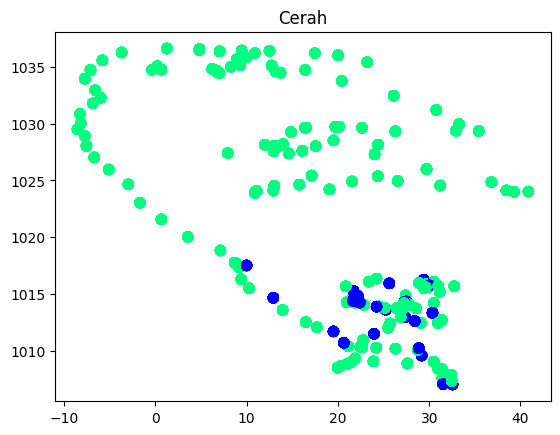

First five rows and col values 
X2 : 
 [[  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]]  
 y2 :
 [1 1 1 1 1]


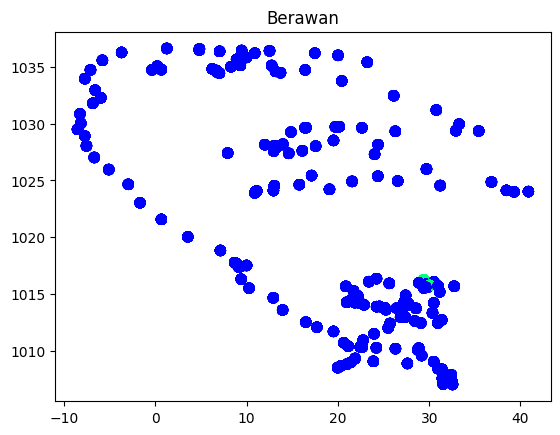

First five rows and col values 
X3 : 
 [[  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]
 [  29.4  1016.25    8.29  285.      0.     23.9     0.  ]]  
 y3 :
 [-1 -1 -1 -1 -1]


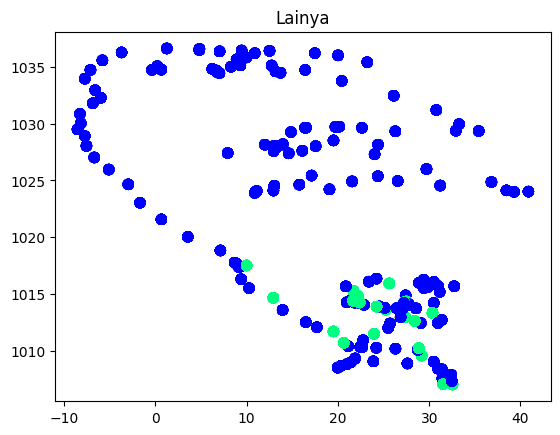

For dataset 1, score: 0.859987929993965


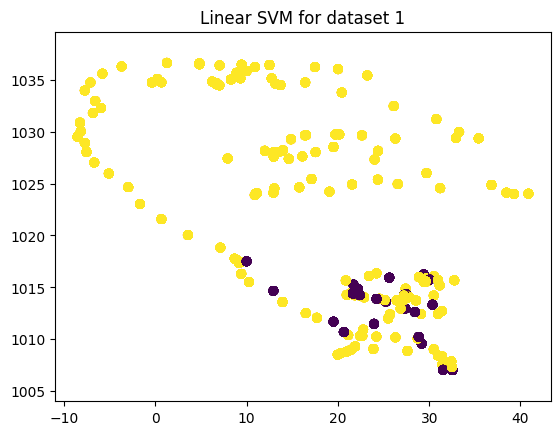

For dataset 2, score: 0.9883323274994971


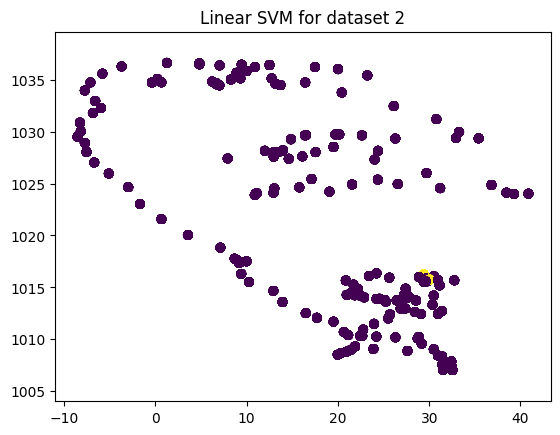

For dataset 3, score: 0.8716556024944679


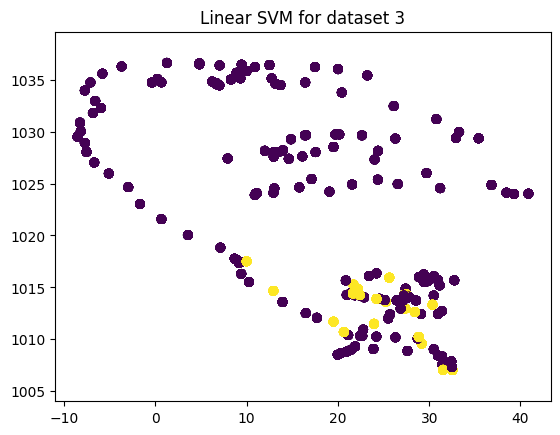

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

file_path = "D:/dataset/HomeC.csv"
df = pd.read_csv(file_path)
#df = df.fillna(df.median())
#df = df.select_dtypes(include=[np.number])  # only keep numeric columns
df =df.dropna()
#df = df.drop_duplicates()
df = df.iloc[58:10000]

#y1 cerah
X1 = df[['apparentTemperature', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']].values
y1 = np.where(df['summary'] == 'Clear', 1, -1)  # Cerah
print("First five rows and col values \nX1 : \n", X1[:5], " \n y1 :\n", y1[:5])
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='winter', alpha=.5)
plt.title("Cerah")
plt.show()

#y2 berawan
X2 = df[['apparentTemperature', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']].values
y2 = np.where(df['summary'] == 'Mostly Cloudy', 1, -1)  # Berawan
print("First five rows and col values \nX2 : \n", X2[:5], " \n y2 :\n", y2[:5])
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='winter', alpha=.5)
plt.title("Berawan")
plt.show()

#y3 lainya
X3 = df[['apparentTemperature', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']].values
y3 = np.where((df['summary'] != 'Clear') & (df['summary'] != 'Mostly Cloudy'), 1, -1)  # Lainnya
print("First five rows and col values \nX3 : \n", X3[:5], " \n y3 :\n", y3[:5])
plt.scatter(X3[:, 0], X3[:, 1], c=y3, s=50, cmap='winter', alpha=.5)
plt.title("Lainya")
plt.show()

# Generating SVM soft Margin
class SVM_soft_margin:
    def __init__(self, alpha=0.001, lambda_=0.01, n_iterations=1000):
        self.alpha = alpha  # learning rate
        self.lambda_ = lambda_  # tradeoff
        self.n_iterations = n_iterations  # number of iterations
        self.w = None  # weights or slopes
        self.b = None  # intercept

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)  # initializing with 0
        self.b = 0  # initialize with 0
        for iteration in range(self.n_iterations):
            for i, Xi in enumerate(X):
                # yixiw-b≥1
                if y[i] * (np.dot(Xi, self.w) - self.b) >= 1:
                    self.w -= self.alpha * (2 * self.lambda_ * self.w)  # w = w + α* (2λw - yixi)
                else:
                    self.w -= self.alpha * (2 * self.lambda_ * self.w - np.dot(Xi, y[i]))  # w = w + α* (2λw - yixi)
                    self.b -= self.alpha * y[i]  # b = b - α* (yi)
        return self.w, self.b

    def predict(self, X):
        pred = np.dot(X, self.w) - self.b
        result = [1 if val > 0 else -1 for val in pred]  # returning in the form of -1 and 1
        return result

    def get_hyperplane(self, x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    def plot_svm(self, X, y, w, b, title='Plot for linear SVM'):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])
        x1_1 = self.get_hyperplane(x0_1, w, b, 0)
        x1_2 = self.get_hyperplane(x0_2, w, b, 0)
        x1_1_m = self.get_hyperplane(x0_1, w, b, -1)
        x1_2_m = self.get_hyperplane(x0_2, w, b, -1)
        x1_1_p = self.get_hyperplane(x0_1, w, b, 1)
        x1_2_p = self.get_hyperplane(x0_2, w, b, 1)
        ax.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
        ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], 'k')
        ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], 'k')
        x1_min = np.amin(X[:, 1])
        x1_max = np.amax(X[:, 1])
        ax.set_ylim([x1_min - 3, x1_max + 3])
        plt.title(title)
        plt.show()

# Implementing into each Datasets
svm1 = SVM_soft_margin()
w1, b1 = svm1.fit(X1, y1)
print("For dataset 1, score:", accuracy_score(svm1.predict(X1), y1))
svm1.plot_svm(X1, y1, w1, b1, title='Linear SVM for dataset 1')

svm2 = SVM_soft_margin()
w2, b2 = svm2.fit(X2, y2)
print("For dataset 2, score:", accuracy_score(svm2.predict(X2), y2))
svm2.plot_svm(X2, y2, w2, b2, title='Linear SVM for dataset 2')

svm3 = SVM_soft_margin()
w3, b3 = svm3.fit(X3, y3)
print("For dataset 3, score:", accuracy_score(svm3.predict(X3), y3))
svm3.plot_svm(X3, y3, w3, b3, title='Linear SVM for dataset 3')




